<a href="https://colab.research.google.com/github/amanzoni1/MoE-Burst-Upcycling/blob/main/HELLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Uninstall the conflicting library
!pip uninstall -y torchvision

# 2. Force install the bleeding-edge Transformers (fixes the missing OLMoE class)
!pip install -U git+https://github.com/huggingface/transformers

# 3. Install core dependencies
!pip install -U torch accelerate peft datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-na7wh8oi
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-na7wh8oi
  Resolved https://github.com/huggingface/transformers to commit a30413b78feed68da5c486746f745db092bfdf9a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
from transformers import OlmoeForCausalLM, AutoTokenizer

model_name = "allenai/OLMoE-1B-7B-0924"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = OlmoeForCausalLM.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/179 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [2]:
print(f"Model Memory Footprint: {model.get_memory_footprint() / 1e9:.2f} GB")

Model Memory Footprint: 13.84 GB


In [8]:
print(torch.cuda.memory_allocated() / 1e9, "GB allocated")
print(torch.cuda.memory_reserved() / 1e9, "GB reserved")

13.838324736 GB allocated
15.453913088 GB reserved


In [9]:
# Quick sanity checks
print("CUDA available:", torch.cuda.is_available())
print("Device:", model.device)
print("VRAM used (GB):", torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else "N/A")

CUDA available: True
Device: cuda:0
VRAM used (GB): 13.838324736


In [6]:
print("\n=== 🔍 MODEL ARCHITECTURE DIG ===")
print(f"Model Class: {type(model).__name__}")

# We only care about the decoder layers where the MoE lives
# Usually found in model.model.layers or model.layers
layers = model.model.layers

print(f"Total Layers: {len(layers)}")

# Let's inspect Layer 0 specifically to find the Router and Experts
layer_0 = layers[0]
print("\n=== 🔬 INSIDE LAYER 0 ===")
for name, module in layer_0.named_modules():
    # Only print top-level components of the layer
    if name.count(".") == 0 and name != "":
        print(f" • {name}: {module.__class__.__name__}")

        # If this is the MoE block, dig deeper
        if "moe" in name.lower():
            print(f"    └── Found MoE Block! Digging deeper...")
            for sub_name, sub_module in module.named_modules():
                if sub_name == "gate":
                    print(f"        👉 ROUTER found: '{name}.{sub_name}' -> {sub_module}")
                if "experts" in sub_name and sub_name.count(".") == 0:
                     print(f"        👉 EXPERTS container: '{name}.{sub_name}' -> Contains {len(sub_module)} experts")


=== 🔍 MODEL ARCHITECTURE DIG ===
Model Class: OlmoeForCausalLM
Total Layers: 16

=== 🔬 INSIDE LAYER 0 ===
 • self_attn: OlmoeAttention
 • mlp: OlmoeSparseMoeBlock
 • input_layernorm: OlmoeRMSNorm
 • post_attention_layernorm: OlmoeRMSNorm


In [5]:
print("\n" + "="*50)
print(f"🏗️  DEEP DIVE: {model_name}")
print("="*50)

# Recursive function to print structure with indent
def print_structure(module, indent=0):
    for name, child in module.named_children():
        prefix = "  " * indent
        print(f"{prefix}├── \033[1m{name}\033[0m: {child.__class__.__name__}")

        # Dig deeper if it's a container or MoE layer
        if list(child.named_children()):
            print_structure(child, indent + 1)

# Start digging from the main model block
# We usually skip the outer 'model' wrapper to save space
print_structure(model)

print("\n" + "="*50)
print("🧐 INSPECTING SPECIFIC PARAMETERS")
print("="*50)

# Let's verify the exact path to the router
found_router = False
for name, module in model.named_modules():
    if "gate" in name or "router" in name:
        print(f"✅ Found potential Router: \033[92m{name}\033[0m")
        print(f"   Type: {module}")
        found_router = True

if not found_router:
    print("❌ Could not auto-detect router name. Check the tree above manually.")


🏗️  DEEP DIVE: allenai/OLMoE-1B-7B-0924
├── model: OlmoeModel
  ├── embed_tokens: Embedding
  ├── layers: ModuleList
    ├── 0: OlmoeDecoderLayer
      ├── self_attn: OlmoeAttention
        ├── q_proj: Linear
        ├── k_proj: Linear
        ├── v_proj: Linear
        ├── o_proj: Linear
        ├── q_norm: OlmoeRMSNorm
        ├── k_norm: OlmoeRMSNorm
      ├── mlp: OlmoeSparseMoeBlock
        ├── gate: OlmoeTopKRouter
        ├── experts: OlmoeExperts
          ├── act_fn: SiLUActivation
      ├── input_layernorm: OlmoeRMSNorm
      ├── post_attention_layernorm: OlmoeRMSNorm
    ├── 1: OlmoeDecoderLayer
      ├── self_attn: OlmoeAttention
        ├── q_proj: Linear
        ├── k_proj: Linear
        ├── v_proj: Linear
        ├── o_proj: Linear
        ├── q_norm: OlmoeRMSNorm
        ├── k_norm: OlmoeRMSNorm
      ├── mlp: OlmoeSparseMoeBlock
        ├── gate: OlmoeTopKRouter
        ├── experts: OlmoeExperts
          ├── act_fn: SiLUActivation
      ├── input_layernorm: OlmoeRMS

In [11]:
import torch
from collections import defaultdict

# 1. SETUP: Define the hook mechanism
# We will store how many times each expert is selected
# { layer_idx: { expert_idx: count } }
activation_counts = defaultdict(lambda: torch.zeros(64, device="cuda"))

def get_router_hook(layer_idx):
    def hook(module, input, output):
        # --- PROBE (DEBUGGING) ---
        # The first time this runs, we print what the output looks like
        # so we are 100% sure we are grabbing the right thing.
        if layer_idx == 0 and activation_counts[0].sum() == 0:
            print(f"\n🕵️ PROBE - Layer {layer_idx} Gate Output Type: {type(output)}")
            if isinstance(output, tuple):
                print(f"   It's a tuple! Length: {len(output)}")
                print(f"   Item 0 shape: {output[0].shape}")
            else:
                print(f"   Shape: {output.shape}")

        # --- THE LOGIC ---
        # OLMoE's router usually outputs 'router_logits' of shape [batch*seq_len, num_experts]
        # We need to calculate which ones are the Top-8 (active ones)

        router_logits = output

        # Handle if it's a tuple (logits usually come first)
        if isinstance(output, tuple):
            router_logits = output[0] # Usually [batch, seq_len, num_experts]

        # Reshape to [total_tokens, num_experts]
        if len(router_logits.shape) == 3:
            router_logits = router_logits.view(-1, router_logits.shape[-1])

        # Find Top-8 Experts (OLMoE standard)
        # We don't care about the values, just the indices
        _, selected_indices = torch.topk(router_logits, k=8, dim=-1)

        # Flatten to a simple list of "all experts selected in this batch"
        indices_flat = selected_indices.flatten()

        # Count them efficiently on GPU
        counts = torch.bincount(indices_flat, minlength=64)
        activation_counts[layer_idx] += counts

    return hook

# 2. ATTACH: Hook every layer
print("🪝 Attaching hooks to model.layers...mlp.gate")
hooks = []
for i, layer in enumerate(model.model.layers):
    # Use the path YOU found: mlp.gate
    h = layer.mlp.gate.register_forward_hook(get_router_hook(i))
    hooks.append(h)

print(f"✅ Attached {len(hooks)} hooks.")

# 3. RUN: Pass some dummy data (or your real data)
# Since we don't have your dataset yet, I'll use a generic sentence to test.
print("\n🚀 Running Forward Pass...")
dummy_text = "The quick brown fox jumps over the lazy dog. " * 10
inputs = tokenizer(dummy_text, return_tensors="pt").to("cuda")

with torch.no_grad():
    _ = model(**inputs)

# 4. REPORT: Who are the "Hot" Experts?
print("\n" + "="*40)
print("🔥 HOT EXPERTS REPORT (Top 3 per layer)")
print("="*40)

hot_experts_map = {} # We save this for the next step

for layer_idx in range(16): # 16 layers
    counts = activation_counts[layer_idx]

    # Get indices of the experts with highest counts
    top_k_indices = torch.topk(counts, k=3).indices.tolist()

    # Calculate usage % (just for your info)
    total_calls = counts.sum().item()
    top_usage = counts[top_k_indices[0]].item()
    percentage = (top_usage / total_calls) * 100 if total_calls > 0 else 0

    print(f"Layer {layer_idx:02d}: Experts {top_k_indices} (Top 1 used {percentage:.1f}%)")

    # Save for HELLoRA config later
    hot_experts_map[layer_idx] = top_k_indices

# 5. CLEANUP: Remove hooks so they don't slow down future runs
for h in hooks:
    h.remove()
print("\n🧹 Hooks removed.")

🪝 Attaching hooks to model.layers...mlp.gate
✅ Attached 16 hooks.

🚀 Running Forward Pass...

🕵️ PROBE - Layer 0 Gate Output Type: <class 'tuple'>
   It's a tuple! Length: 3
   Item 0 shape: torch.Size([101, 64])

🔥 HOT EXPERTS REPORT (Top 3 per layer)
Layer 00: Experts [6, 41, 42] (Top 1 used 7.7%)
Layer 01: Experts [5, 37, 9] (Top 1 used 8.8%)
Layer 02: Experts [5, 38, 48] (Top 1 used 7.9%)
Layer 03: Experts [61, 31, 10] (Top 1 used 9.4%)
Layer 04: Experts [43, 63, 39] (Top 1 used 9.4%)
Layer 05: Experts [0, 37, 60] (Top 1 used 8.8%)
Layer 06: Experts [57, 10, 31] (Top 1 used 11.1%)
Layer 07: Experts [4, 0, 35] (Top 1 used 10.9%)
Layer 08: Experts [27, 51, 6] (Top 1 used 10.9%)
Layer 09: Experts [51, 9, 14] (Top 1 used 10.5%)
Layer 10: Experts [22, 20, 44] (Top 1 used 11.0%)
Layer 11: Experts [47, 7, 14] (Top 1 used 11.0%)
Layer 12: Experts [32, 45, 26] (Top 1 used 8.8%)
Layer 13: Experts [59, 16, 39] (Top 1 used 10.8%)
Layer 14: Experts [4, 17, 35] (Top 1 used 11.3%)
Layer 15: Exper

⚡ Profiling: Math/Logic...
⚡ Profiling: Fiction/Story...


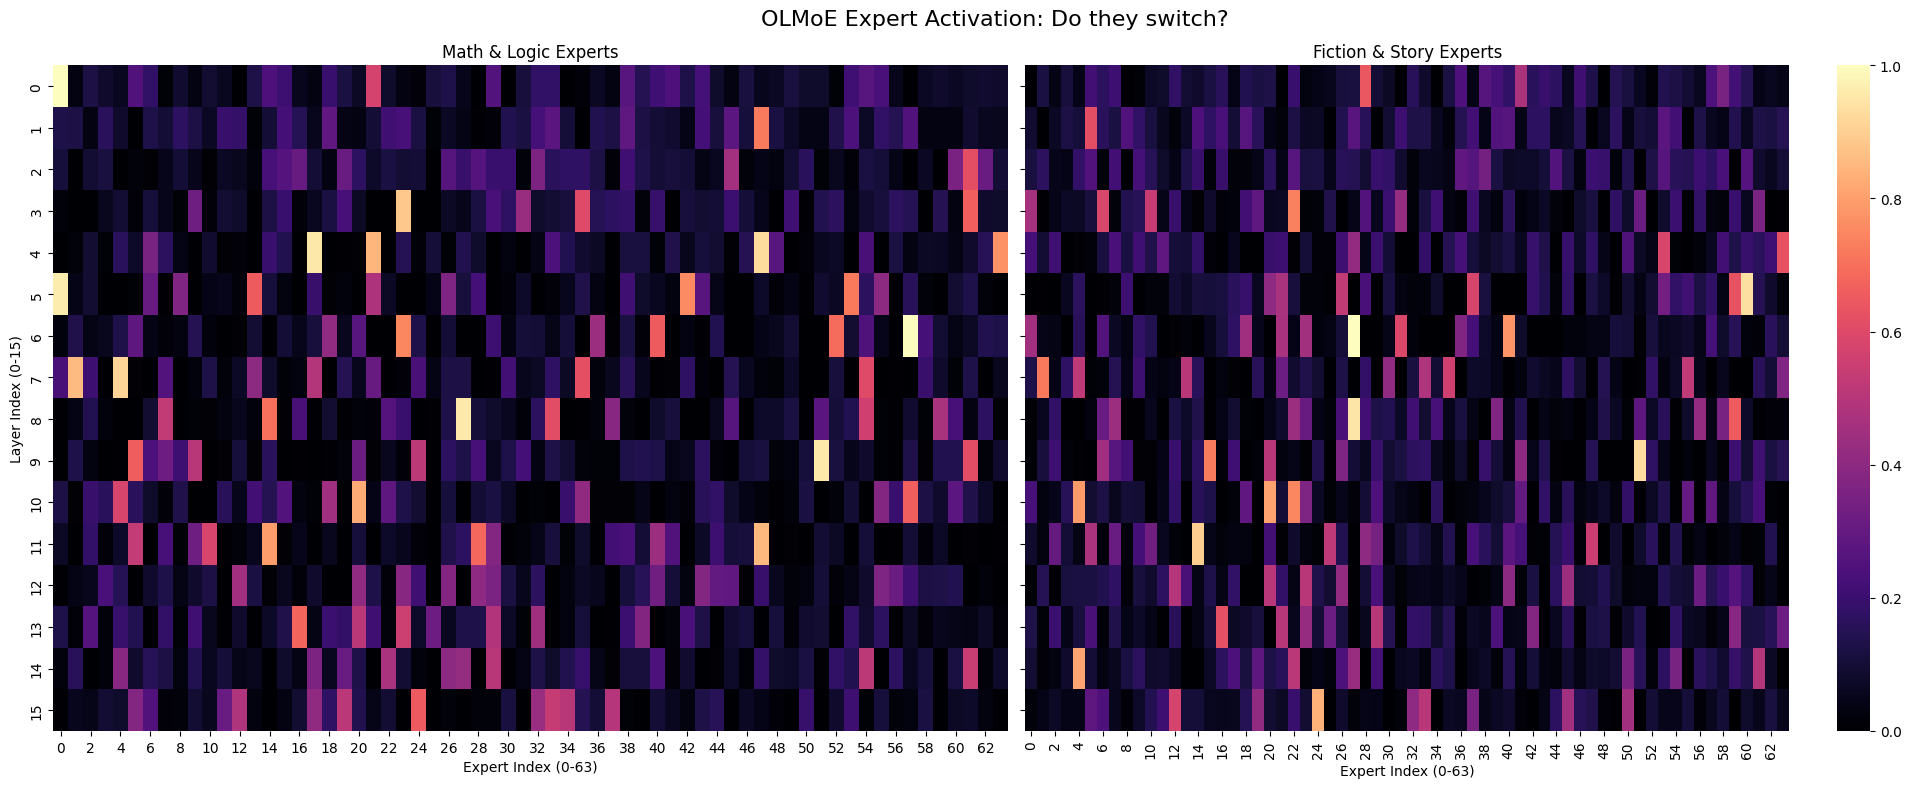


📊 Difference Score (Mean Abs Diff): 0.0968
If this score is low (<0.05), the model uses the SAME experts for everything.
If this score is high (>0.1), the model is truly specializing.


In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Define Two Distinct Datasets
text_math = (
    "Let f(x) be a polynomial of degree 4. Calculate the derivative of f(x) "
    "and find the roots where f'(x) = 0. The integral of the function is defined as... "
    "Solve for x in the equation 2x + 5 = 15. The geometry of the triangle implies..."
) * 20

text_fiction = (
    "The sunlight drifted through the leaves, casting long shadows on the forest floor. "
    "She whispered softly, her voice trembling with emotion. 'I cannot leave you,' she said. "
    "The ancient castle stood on the hill, a silent sentinel watching over the valley..."
) * 20

# 2. The Profiler Function (Reusing your successful hook logic)
def profile_experts(text_input, tag):
    print(f"⚡ Profiling: {tag}...")

    # Reset counts
    layer_counts = torch.zeros((16, 64), device="cuda")

    def get_hook(layer_idx):
        def hook(module, input, output):
            # Router output handling (OLMoE specific)
            router_logits = output[0] if isinstance(output, tuple) else output
            if len(router_logits.shape) == 3:
                router_logits = router_logits.view(-1, router_logits.shape[-1])

            # Top-8
            _, indices = torch.topk(router_logits, k=8, dim=-1)

            # Count
            counts = torch.bincount(indices.flatten(), minlength=64)
            layer_counts[layer_idx] += counts
        return hook

    # Attach hooks
    hooks = []
    for i, layer in enumerate(model.model.layers):
        hooks.append(layer.mlp.gate.register_forward_hook(get_hook(i)))

    # Run
    inputs = tokenizer(text_input, return_tensors="pt").to("cuda")
    with torch.no_grad():
        model(**inputs)

    # Cleanup
    for h in hooks: h.remove()

    return layer_counts.cpu().numpy()

# 3. Run Both Profiles
heatmap_math = profile_experts(text_math, "Math/Logic")
heatmap_fiction = profile_experts(text_fiction, "Fiction/Story")

# Normalize (0 to 1 scale for fair comparison)
# We divide by the max value in each map so colors are relative to THAT run
heatmap_math_norm = heatmap_math / (heatmap_math.max() + 1e-9)
heatmap_fiction_norm = heatmap_fiction / (heatmap_fiction.max() + 1e-9)

# 4. Plot Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

sns.heatmap(heatmap_math_norm, ax=axes[0], cmap="magma", cbar=False)
axes[0].set_title("Math & Logic Experts")
axes[0].set_xlabel("Expert Index (0-63)")
axes[0].set_ylabel("Layer Index (0-15)")

sns.heatmap(heatmap_fiction_norm, ax=axes[1], cmap="magma", cbar=True)
axes[1].set_title("Fiction & Story Experts")
axes[1].set_xlabel("Expert Index (0-63)")

plt.suptitle(f"OLMoE Expert Activation: Do they switch?", fontsize=16)
plt.tight_layout()
plt.show()

# 5. Calculate "Switch Rate" (Scientific verification)
# We check how different the top experts are
diff = np.abs(heatmap_math_norm - heatmap_fiction_norm)
print(f"\n📊 Difference Score (Mean Abs Diff): {diff.mean():.4f}")
print("If this score is low (<0.05), the model uses the SAME experts for everything.")
print("If this score is high (>0.1), the model is truly specializing.")